<a href="https://colab.research.google.com/github/kumagaimasahito/Ising-based_Kernel_Clustering/blob/main/Ising_based_Kernel_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install dwave-neal # Neal simulated annealing sampler is used in this sample code.

In [2]:
from neal import SimulatedAnnealingSampler
from sklearn import datasets
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import collections

In [3]:
# "set_gaussian_matrix", "set_gram_matrix", and "set_qubo" are core functions of IsingKernelClustering class.

class IsingKernelClustering:
    def __init__(self, *, data, n_clusters, sigma=0.2):
        self.data = data
        self.n_points = len(data)
        self.n_clusters = n_clusters
        self.sigma = sigma
        self.label2index = {
            (i,a):i*n_clusters+a
            for i in range(self.n_points)
            for a in range(n_clusters)
        }
        self.index2label = {
            i*n_clusters+a:(i,a)
            for i in range(self.n_points)
            for a in range(n_clusters)
        }

    def set_gaussian_matrix(self):
        dists = distance.cdist(self.data, self.data, 'sqeuclidean')
        self.kernel_matrix = np.exp(-dists/(2*self.sigma**2))

    def set_gram_matrix(self):
        mean_row = np.mean(self.kernel_matrix, axis=1).reshape(self.n_points,1)
        mean_col = np.mean(self.kernel_matrix, axis=0).reshape(1,self.n_points)
        mean_all = np.mean(self.kernel_matrix)
        self.gram_matrix = self.kernel_matrix - mean_row - mean_col + mean_all

    def set_qubo(self):
        self.set_gaussian_matrix()
        self.set_gram_matrix()
        gram_min = self.gram_matrix.min()
        lam = -2*gram_min
        self.qubo = {
            ((i,a),(j,b)) :
            -(self.gram_matrix[i,j]+self.gram_matrix[j,i]) if (i<j and a==b)
            else -(self.gram_matrix[i,j]+lam) if (i==j and a==b)
            else 2*lam if (i==j and a<b)
            else 0
            for i in range(0,self.n_points)
            for j in range(i,self.n_points)
            for a in range(0,self.n_clusters)
            for b in range(a,self.n_clusters)
        }

    def get_solution(self, settings={}, parameters={}):
        sampler = SimulatedAnnealingSampler(**settings)
        self.response = sampler.sample_qubo(self.qubo, **parameters)
        self.solution = self.response.first.sample.values()

    def solution2label(self):
        dict_solution = {
            self.index2label[i]:q
            for i,q in enumerate(self.solution)
        }
        self.label = [
            -1 if (
                collections.Counter(
                    [
                        dict_solution[i,j]
                        for j in range(self.n_clusters)
                    ]
                )[1]!=1
            )
            else [
                dict_solution[i,j]
                for j in range(self.n_clusters)
            ].index(1)
            for i in range(self.n_points)
        ]

    def run(self):
        self.set_qubo()
        self.get_solution()
        self.solution2label()

In [4]:
# make a data comprising two half circles that interleave for input.
data, labels_origin = datasets.make_moons(n_samples=50, noise=0.05, random_state=0)

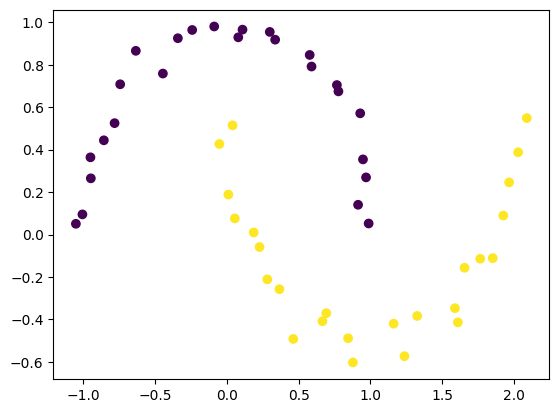

In [5]:
# plot by answer label
plt.scatter(data[:,0], data[:,1], c=labels_origin)
plt.show()

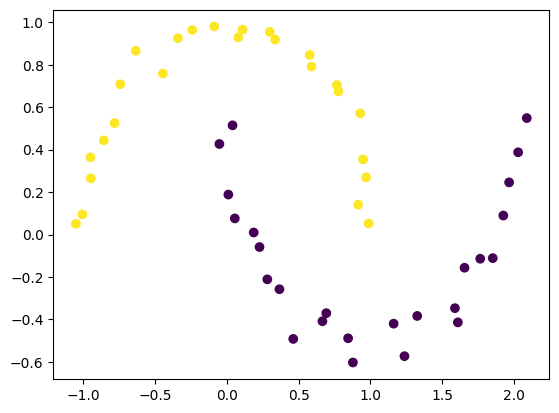

In [6]:
# run Ising-based Kernel Clusetring
ikc = IsingKernelClustering(data=data, n_clusters=2, sigma=0.2)
ikc.set_qubo()
ikc.get_solution(parameters={"num_reads": 100, "num_sweeps": 1000})
ikc.solution2label()

# plot by the label given by the simulated annealing
plt.scatter(data[:,0], data[:,1], c=ikc.label)
plt.show()